# Explore bias-correction

This notebook served as the initial development environment for experimenting with bias adjustment of simulated GCM data using `xclim`.  In its final form, it now serves as a record of how we will go about developing our production bias-adjusted dataset. Note, one thing that was

With `xclim` we have at our disposal a number of different methods of adjustment, as well as multiple "knobs" to turn to tweak those methods. There is more functionality available than we have capacity for evaluating and finding a "best" method, and this could be the subject of a future project.

Rather, we will use [Lavoie et al 2024](https://doi.org/10.1038/s41597-023-02855-z) as a defensible template to follow. Given the publication (Scientific Data, a high-impact data journal under the Nature umbrella). The authors used detrended quantile mapping for the same variables we are planning to adjust (at least, initially): daily maximum temperature ($T_{max}$), daily minimum temperature ($T_{max}$), and precipitation ($Pr$). 

##### Bias-correction or bias-adjustment??

Lavoie et al 2024 almost exclusively use bias-**adjustment** in their article. However, most of the literature seems to use bias-**correction**. This pipeline will aim for internal consistency using "adjustment", given its prominence in the `xclim` framework ("train-adjust"), the fact that this is a newer paper and so might represent somewhat of an evolution, and "adjustment" feels better to [KR] than "correction" because we don't really know how "correct" the resulting data are.

## Bias-adjustment example

Here we will step through what we have learned in developing this workflow by performing a bias-adjustment using the exact<sup>*</sup> method we plan to implement for all input data. 



<sup>*</sup> The one difference between adjusting $Pr$ and the other variables is that we will use a multiplicative adjustment instead of additive.

Load the libs:

(This notebook will make use of the `dask-jobqueue` to run this example on a Chinook compute node via slurmn)

In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
from dask.distributed import Client
from xclim.sdba.detrending import LoessDetrend
from dask_jobqueue import SLURMCluster

/home/kmredilla/miniconda3/envs/dask_env/lib/python3.11/site-packages/xclim/indices/fire/_cffwis.py:217: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/kmredilla/miniconda3/envs/dask_env/lib/python3.11/site-packages/xclim/indices/fire/_cffwis.py:237: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


Directories for the prepped ERA5 and the regridded CMIP6 data:

In [2]:
era5_dir = Path("/center1/CMIP6/kmredilla/era5/daily_regrid/")
cmip6_dir = Path("/beegfs/CMIP6/arctic-cmip6/regrid")
cmip6_tmp_fn = "{var_id}_day_{model}_{scenario}_regrid_{year}0101-{year}1231.nc"

log_dir = "."

Set up a slurm cluster and dask client:

In [3]:
# dunno really how to set this, but it works for now
cluster = SLURMCluster(
    cores=8,
    memory="32GB",
    queue="t2small",
    walltime="02:00:00",
    log_directory=log_dir,
    account="cmip6",
    interface="ib0",
)

In [4]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.55.40.4:8787/status,
Dashboard: http://10.55.40.4:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.55.40.4:34811,Workers: 0
Dashboard: http://10.55.40.4:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Fire up the cluster:

In [5]:
cluster.scale(1)

We will aim to perform the adjustment using 1993-2022 as the reference period. This reference period is subject to change in the main pipeline, but it was chosen here because Lavoie et al 2024 simply chose the most recent 30-year period of available data at the time of development. We could potentially use 1994-2023 if we wanted to go even more recent, but that would require downloading extra ERA5 data.

Because this time period overlaps the dividing year between ScenarioMIP data and CMIP historical experiments, 2015, we will combine data from the two for performing the bias adjustment. This means we will eventually be recycling the simulated historical data of 1993-2014 for each future scenario for the production processing. 

We will execute a test run with $T_{max}$ for GFDL-ESM4, using the SSP5-8.5 scenario. Get the relevant filepaths:

In [6]:
# "tas" in ERA5 is t2m, so we have named the daily max version t2mmax
ref_var_id = "t2mmax"
ref_start_year = 1993
ref_end_year = 2022
ref_fps = [
    era5_dir.joinpath(ref_var_id).joinpath(f"era5_daily_regrid_{ref_var_id}_{year}.nc")
    for year in range(ref_start_year, ref_end_year + 1)
]


var_id = "tasmax"
model = "GFDL-ESM4"

hist_start_year = 1993
hist_end_year = 2014

hist_fps = [
    cmip6_dir.joinpath(
        model,
        "historical",
        "day",
        var_id,
        cmip6_tmp_fn.format(
            var_id=var_id, model=model, scenario="historical", year=year
        ),
    )
    for year in range(hist_start_year, hist_end_year + 1)
]

scenario = "ssp585"
sim_ref_start_year = 2015
sim_ref_end_year = 2022
sim_ref_fps = [
    cmip6_dir.joinpath(
        model,
        scenario,
        "day",
        var_id,
        cmip6_tmp_fn.format(var_id=var_id, model=model, scenario=scenario, year=year),
    )
    for year in range(sim_ref_start_year, sim_ref_end_year + 1)
]

Open the datasets from the yearly data files for each of ERA5 and CMIP6:

In [7]:
hist_ds = xr.open_mfdataset(hist_fps + sim_ref_fps)
# convert calendar to noleap to match CMIP6
ref_ds = xr.open_mfdataset(ref_fps).convert_calendar("noleap")

Sample plot check:

Text(0.5, 1.0, 'Historical simulated')

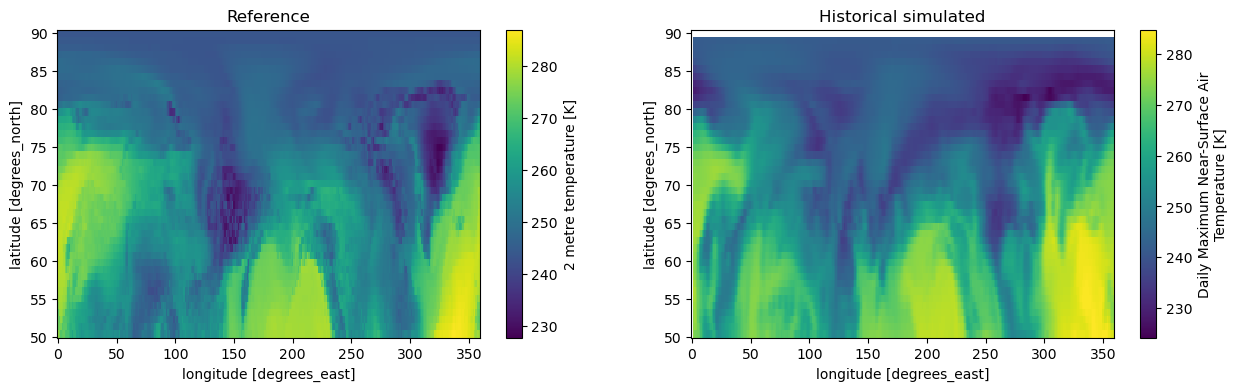

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

ref_ds["t2mmax"].isel(time=1).plot(ax=axes[0])
axes[0].set_title("Reference")
hist_ds["tasmax"].isel(time=1).plot(ax=axes[1])
axes[1].set_title("Historical simulated")

Okay, here is a dask gotchya: you cannot use the training functions in `xclim.sdba` with datasets having chunks along the adjustment dimension (time in this case) so we need to rechunk it into one. We split it up into chunks over the lat and lon dims for some added optimization (hopefully).

We will also initialize the bias adjustment here. We are performing a "detrended" quantile mapping grouped by day of the year. To quote Lavoie et al 2024:

>The procedure is univariate (applied to each variable individually), acts independently on the trends and the anomalies, and is applied iteratively on each day of the year as well as at each grid point.

Other parameters can be seen below. Not sure what they all mean, but we are using 50 quantiles and a window of 31 days. More info on the window

The final adjusted output will be stored in `scen`, which is currently just a dask task graph until we call `.compute()` on it, or need the data in some way.

In [ ]:
ref = ref_ds["t2mmax"]
hist = hist_ds["tasmax"]
ref.data = ref.data.rechunk({0: -1, 1: 20, 2: 20})
hist.data = hist.data.rechunk({0: -1, 1: 20, 2: 20})

from xclim.sdba.detrending import LoessDetrend

dqm = sdba.DetrendedQuantileMapping.train(
    ref, hist, nquantiles=50, group="time.dayofyear", window=31, kind="+"
)
# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")
scen = dqm.adjust(hist, extrapolation="constant", interp="nearest", detrend=det)

Then run it:

In [9]:
# scen.compute()

Do some plotting to evaluate:

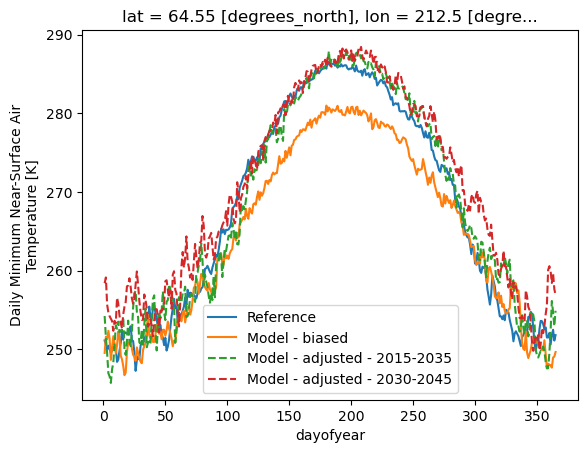

In [27]:
sel_di = {"lon": 213, "lat": 65}
ref.sel(sel_di, method="nearest").groupby("time.dayofyear").mean().plot(
    label="Reference"
)
hist.sel(sel_di, method="nearest").groupby("time.dayofyear").mean().plot(
    label="Model - biased"
)
scen.sel(sel_di, method="nearest").groupby(
    "time.dayofyear"
).mean().plot(label="Model - adjusted", linestyle="--")

plt.legend()